In [79]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import nltk

random.seed(6)
np.random.seed(6)


# Experiment 7 - Llama3.1 8b as a judge

In this experiment I implement the technique `LLM as judge` used in the paper `How good is my MML?` as evaluaiton metric for the correctness of the answers given by a model. The method 
consists of using a LLM to evaluate the correctness of the answers given by another model. The LLM acts as a judge by comparing the predicted answer with the ground truth answer and providing a score between 0 and 5, expressing the confidence in the answer. The judge also provides a reason for the score.


**Parameters:**
- model: llama3.1 8b
- system prompt: LLM_judge_system.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [80]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading the the Judge evaluation on the originally incorrect answers

We first check what are the prediction of the 'Judge' for the set of answer taht were branded as incorrect by the method with the regex answer extraction.

In [81]:
# Load the scores for the wrong answers
predictions = []
with open('../outputs/llama8b_as_judge_wrong.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df.set_index('id', inplace=True)
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_40,incorrect,2,The predicted answer is incorrect because it s...
Interaction_T1_71,incorrect,2,The predicted answer is incorrect because it i...
Interaction_T1_78,incorrect,0,The predicted answer is incorrect because it d...
Interaction_T1_95,incorrect,0,The predicted answer is incorrect because it c...
Interaction_T1_100,incorrect,2,The predicted answer is incorrect because it s...
...,...,...,...
Feasibility_T6_1414,incorrect,2,"The predicted answer ""throw the bag"" does not ..."
Feasibility_T6_1430,incorrect,0,The predicted answer 'Take the pillow' is not ...
Feasibility_T6_1454,incorrect,2,The predicted answer is wiping the table (acti...


In [82]:
judge_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3862 entries, Interaction_T1_40 to Feasibility_T6_1456
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    3862 non-null   string
 1   score   3862 non-null   int32 
 2   reason  3862 non-null   string
dtypes: int32(1), string(2)
memory usage: 105.6+ KB


In [83]:

pred_percentages = judge_pred_df['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)


Predictions:
------------------------------
incorrect :  95.65%
correct   :   4.35%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Load the orignal model predictions to verify the judgement of the model.

In [84]:
original_pred = []
with open('../data/llama3b_wrongs.jsonl') as f:
    original_pred = [json.loads(line) for line in f.readlines()]

original_pred_df = pd.DataFrame(original_pred).astype({'question_id': 'string', 'response': 'string'})
original_pred_df.rename(columns={'question_id': 'id'}, inplace=True)
original_pred_df.set_index('id', inplace=True)

In [85]:
judged_correct_mask = judge_pred_df['pred'] == 'correct'

original_pred_df.loc[judged_correct_mask]

,response
id,
Interaction_T1_375,<Reasoning> The question asks which object was...
Interaction_T1_393,<Reasoning> To determine which object was tidi...
Interaction_T1_1312,"<Reasoning> To answer this question, we need t..."
Interaction_T1_1513,<Reasoning> To determine which object was clos...
Interaction_T1_1680,<Reasoning> To determine which object was take...
...,...
Feasibility_T5_902,<Reasoning> The question asks which object the...
Feasibility_T5_906,<Reasoning> The question asks which object the...
Feasibility_T5_928,"<Reasoning> To answer this question, we need t..."


Let's analyze some of the answers

First we execute the usual pipeline to extract the answers with a regex.

In [86]:
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\b(?:\w\/?)+\s*){,10}\.)'

extracted_ans_df = original_pred_df['response'].str.extract(ans_regex_pattern)
extracted_ans_df.rename(columns={0: 'text'}, inplace=True)

extracted_ans_df['text'] = extracted_ans_df['text'].str.strip()
extracted_ans_df

,text
id,
Interaction_T1_40,The blanket.
Interaction_T1_71,The shoe.
Interaction_T1_78,The refrigerator.
Interaction_T1_95,The clothes.
Interaction_T1_100,The clothes.
...,...
Feasibility_T6_1414,Throw the bag.
Feasibility_T6_1430,Take the pillow.
Feasibility_T6_1454,Wipe the table.


In [87]:
idx = 'Interaction_T1_375'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {extracted_ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{original_pred_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")

Index: Interaction_T1_375
Question: Which object was taken by the person?
Ground truth answer: The blanket.
Extracted answer: The clothes.

Original answer:

<Reasoning>
The question asks which object was taken by the person. To answer this, we need to look for a Scene-Graph that contains the relationship "holding" between the person and another object.

Upon examining the Spatio-Temporal Scene-Graphs in chronological order, I notice that the first Scene-Graph contains the relationship "holding - clothes". This suggests that the person is holding the clothes. However, we need to consider if this is the only instance where the person is taking an object.

Looking at the subsequent Scene-Graphs, I see that the pattern of the person holding the clothes continues throughout the sequence. There are no other instances where the person is seen holding another object, such as the phone, food, or towel.

Therefore, based on the information provided in the Spatio-Temporal Scene-Graphs, it appear

The model seems confident that the predicted answer mathces the ground truth but as we can see above this is not true.  
Can it be an error in the prompt? Or did the judge llm *"hallucinate"*?

In [88]:
prompts = []
with open('../data/llama3b_judged_prompts.jsonl') as f:
    prompts = [json.loads(line) for line in f.readlines()]

prompts_df = pd.DataFrame(prompts)
prompts_df.rename(columns={'qid': 'id'}, inplace=True)
prompts_df.set_index('id', inplace=True)
prompts_df

,prompt
id,
Interaction_T1_13,Please evaluate the following question-answer ...
Interaction_T1_14,Please evaluate the following question-answer ...
Interaction_T1_31,Please evaluate the following question-answer ...
Interaction_T1_32,Please evaluate the following question-answer ...
Interaction_T1_40,Please evaluate the following question-answer ...
...,...
Feasibility_T6_1453,Please evaluate the following question-answer ...
Feasibility_T6_1454,Please evaluate the following question-answer ...
Feasibility_T6_1455,Please evaluate the following question-answer ...


In [89]:
print(prompts_df.loc[idx]['prompt'])

Please evaluate the following question-answer pair:
Question: Which object was taken by the person?

Ground truth correct Answer: 
[START ANSWER]
The blanket.
[END ANSWER]

Predicted Answer:
[START PREDICTION]
<Reasoning>
The question asks which object was taken by the person. To answer this, we need to look for a Scene-Graph that contains the relationship "holding" between the person and another object.

Upon examining the Spatio-Temporal Scene-Graphs in chronological order, I notice that the first Scene-Graph contains the relationship "holding - clothes". This suggests that the person is holding the clothes. However, we need to consider if this is the only instance where the person is taking an object.

Looking at the subsequent Scene-Graphs, I see that the pattern of the person holding the clothes continues throughout the sequence. There are no other instances where the person is seen holding another object, such as the phone, food, or towel.

Therefore, based on the information pro

As we can see above, the prompt reported the ground truth accurately, thus is the model that missed completely the prediction.

Let's inspect more samples...

In [90]:
idx = random.choice(judged_correct_mask[judged_correct_mask].index)


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {extracted_ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{original_pred_df.loc[idx]['response']}")
print(f"\nJudge decision:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")

Index: Prediction_T3_147
Question: Which object would the person put down next?
Ground truth answer: The picture.
Extracted answer: The box.

Original answer:

<Reasoning>
To determine which object the person would put down next, we need to analyze the sequence of events unfolding in the scene. The person is currently holding a book and standing in front of a table. In the previous frame, they were touching a picture and standing in front of it.

Looking at the Scene-Graphs, we can see that after the person touches the picture, they put it down. Then, they pick up the box and place it on the table. However, there is no indication that they would put the box down next.

The only object that appears to be being handled by the person in a way that suggests they might put it down next is the book. The person has been holding the book since the beginning of the sequence, and it's possible that they will put it down when they are done with it.

Therefore, based on this analysis, I would choo

After manual inspecting 20 randomly selected samples from those for which the LLM decision differs from the predection obtained with the regex extraction method, I have found that both fail to some degree, therfore for samples the LLM judgment is correct meaning that the sample is wrongly misclassified by the answer extraction method. In other cases, however, the judge LLM wrongly classifies the prediction of the predictor LLM as correct even tough it does not match the ground truth.

TODO: Try moving the ground truth part in the system part, pervious experiments have shown that the LLM tends to follow what is in the system prompt more strictly.

In [91]:
actually_correct = [
'Prediction_T3_819', 
'Sequence_T5_2830', 
'Sequence_T3_5266', 
'Interaction_T1_2063', 
'Sequence_T2_1682', 
'Sequence_T1_3189', 
'Sequence_T4_2776', 
'Interaction_T2_3880', 
'Sequence_T1_3074', 
'Sequence_T2_51', 
'Sequence_T3_1340'
]

actually_wrong = [
'Sequence_T3_96',
'Sequence_T6_3840',
'Prediction_T2_1112',
'Prediction_T2_476',
'Prediction_T4_1644',
'Interaction_T2_2489',
'Sequence_T4_3651',
'Interaction_T2_2623',
'Sequence_T3_3359'
]

### Distribution of confidence score

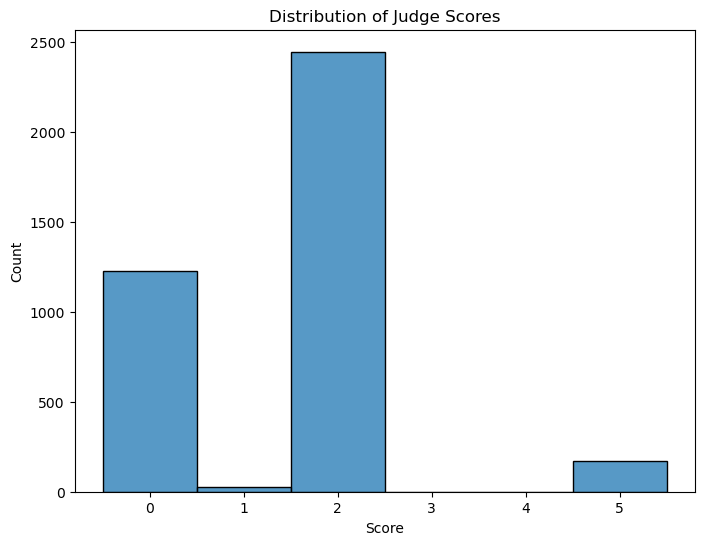

In [92]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

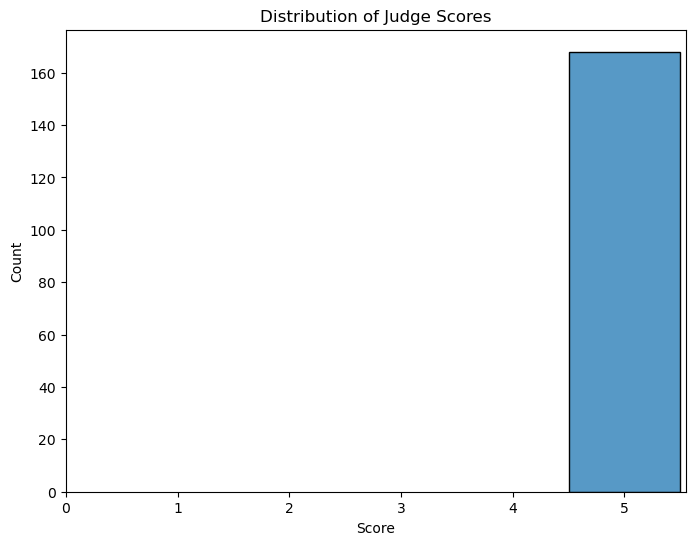

In [93]:
# Now the score distribution for the prediction which the judge considers as correct answer

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df[judged_correct_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()

Not good. The LLM is very confident for these set of answers, even though we have just verified that not all them are consitent with the ground truth.

## Loading the evaluation for the originally correct answers

In [94]:
# Load the scores for the wrong answers
predictions = []
with open('../outputs/llama8b_as_judge_correct.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df.set_index('id', inplace=True)
judge_pred_df


,pred,score,reason
id,,,
Interaction_T1_13,correct,5,The predicted answer matches the ground truth ...
Interaction_T1_14,correct,5,The predicted answer matches the ground truth ...
Interaction_T1_32,correct,5,The predicted answer accurately identifies the...
Interaction_T1_43,correct,5,The predicted answer matches the ground truth ...
Interaction_T1_81,correct,5,The predicted answer matches the ground truth ...
...,...,...,...
Feasibility_T6_1428,correct,5,The predicted answer matches the ground truth ...
Feasibility_T6_1448,correct,5,The predicted answer matches the ground truth ...
Feasibility_T6_1449,correct,5,The predicted answer is correct because it dir...


In [95]:
judge_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3038 entries, Interaction_T1_13 to Feasibility_T6_1468
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pred    3038 non-null   string
 1   score   3038 non-null   int32 
 2   reason  3038 non-null   string
dtypes: int32(1), string(2)
memory usage: 83.1+ KB


In [96]:
pred_percentages = judge_pred_df['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)


Predictions:
------------------------------
incorrect :  22.28%
correct   :  77.72%
------------------------------


An interesting metric, on 95% of the cases the model is concording with the deterministic classification of the answer regex extraction method

Load the orignal model predictions to verify the judgement of the model.

In [97]:
original_pred = []
with open('../data/llama3b_correct.jsonl') as f:
    original_pred = [json.loads(line) for line in f.readlines()]

original_pred_df = pd.DataFrame(original_pred).astype({'question_id': 'string', 'response': 'string'})
original_pred_df.rename(columns={'question_id': 'id'}, inplace=True)
original_pred_df.set_index('id', inplace=True)

In [99]:
judged_incorrect_mask = judge_pred_df['pred'] == 'incorrect'

original_pred_df.loc[judged_incorrect_mask]

,response
id,
Interaction_T1_171,<Reasoning> To determine which object was put ...
Interaction_T1_198,"<Reasoning> To answer this question, we need t..."
Interaction_T1_226,<Reasoning> The question asks which object was...
Interaction_T1_298,<Reasoning> The question asks which object was...
Interaction_T1_460,<Reasoning> The person is performing an action...
...,...
Feasibility_T6_1090,"<Reasoning> To answer this question, we need t..."
Feasibility_T6_1275,<Reasoning> The person is initially sitting on...
Feasibility_T6_1298,"<Reasoning> To answer this question, we need t..."


Let's analyze some of the answers

First we execute the usual pipeline to extract the answers with a regex.

In [100]:
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\b(?:\w\/?)+\s*){,10}\.)'

extracted_ans_df = original_pred_df['response'].str.extract(ans_regex_pattern)
extracted_ans_df.rename(columns={0: 'text'}, inplace=True)

extracted_ans_df['text'] = extracted_ans_df['text'].str.strip()
extracted_ans_df

,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_43,The clothes.
Interaction_T1_81,The sofa/couch.
...,...
Feasibility_T6_1428,Take the cup/glass/bottle.
Feasibility_T6_1448,Put down the laptop.
Feasibility_T6_1449,Put down the laptop.


In [101]:
idx = 'Interaction_T1_171'


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {extracted_ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{original_pred_df.loc[idx]['response']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")

Index: Interaction_T1_171
Question: Which object was put down by the person?
Ground truth answer: The shoe.
Extracted answer: The shoe.

Original answer:

<Reasoning>
To determine which object was put down by the person, we need to analyze the sequence of events. The person is initially wearing a shoe and standing on the floor. As they move around, their position changes, but the shoe remains in contact with the ground.

The first scene-graph shows the person wearing the shoe and standing on the floor, indicating that the shoe has not been put down yet. However, subsequent scene-graphs show the person moving towards a location where they are no longer standing on the floor, suggesting that they have placed the shoe down.

In particular, Scene-Graph 2 shows the person wearing the shoe and standing on the floor, while Scene-Graph 3 shows the person wearing the shoe and standing on the ground. This implies that the person has put the shoe down at some point between these two scenes.

The 

Let's inspect more samples...

In [102]:
idx = random.choice(judged_incorrect_mask[judged_incorrect_mask].index)


print(f"Index: {idx}")
print(f"Question: {gt_df.loc[idx]['question']}")
print(f"Ground truth answer: {gt_df.loc[idx]['text']}")
print(f"Extracted answer: {extracted_ans_df.loc[idx]['text']}")
print(f"\nOriginal answer:\n\n{original_pred_df.loc[idx]['response']}")
print(f"\nJudge decision:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")

Index: Interaction_T1_7151
Question: Which object was lied on by the person?
Ground truth answer: The floor.
Extracted answer: The floor.

Original answer:

<Reasoning>
To answer this question, we need to analyze the Scene-Graphs in chronological order. The person is first touching a window and then standing in front of it.

The next relevant Scene-Graph shows that the person is lying on the floor. This indicates that the person has moved from being in front of the window to lying on the floor.

Since there are multiple instances of the person lying on the floor, we can conclude that the person was lied on by the floor at some point during this sequence.

Therefore, based on the given Scene-Graphs, the correct answer is:
A: 0. The floor.

Judge decision:
 - verdict: incorrect
 - score: 2
 - reason: The predicted answer is incorrect because it incorrectly states that the person was lied on by the floor at some point during the sequence The correct interpretation of the Scene-Graphs show

After manual inspecting 20 randomly selected samples from those for which the LLM decision differs from the predection obtained with the regex extraction method, I have found that both fail to some degree, therfore for samples the LLM judgment is correct meaning that the sample is wrongly misclassified by the answer extraction method. In other cases, however, the judge LLM wrongly classifies the prediction of the predictor LLM as correct even tough it does not match the ground truth.

TODO: Try moving the ground truth part in the system part, pervious experiments have shown that the LLM tends to follow what is in the system prompt more strictly.

In [ ]:
actually_correct = [
'Prediction_T3_819', 
'Sequence_T5_2830', 
'Sequence_T3_5266', 
'Interaction_T1_2063', 
'Sequence_T2_1682', 
'Sequence_T1_3189', 
'Sequence_T4_2776', 
'Interaction_T2_3880', 
'Sequence_T1_3074', 
'Sequence_T2_51', 
'Sequence_T3_1340'
]

actually_wrong = [
'Sequence_T3_96',
'Sequence_T6_3840',
'Prediction_T2_1112',
'Prediction_T2_476',
'Prediction_T4_1644',
'Interaction_T2_2489',
'Sequence_T4_3651',
'Interaction_T2_2623',
'Sequence_T3_3359'
]

### Distribution of confidence score

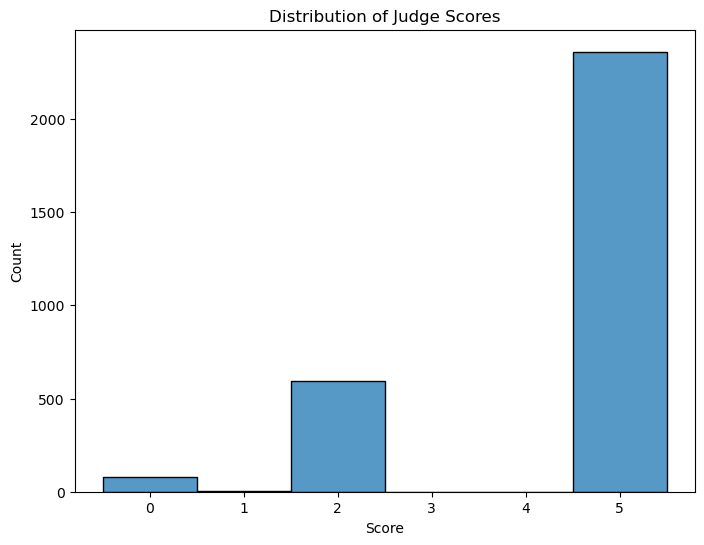

In [103]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

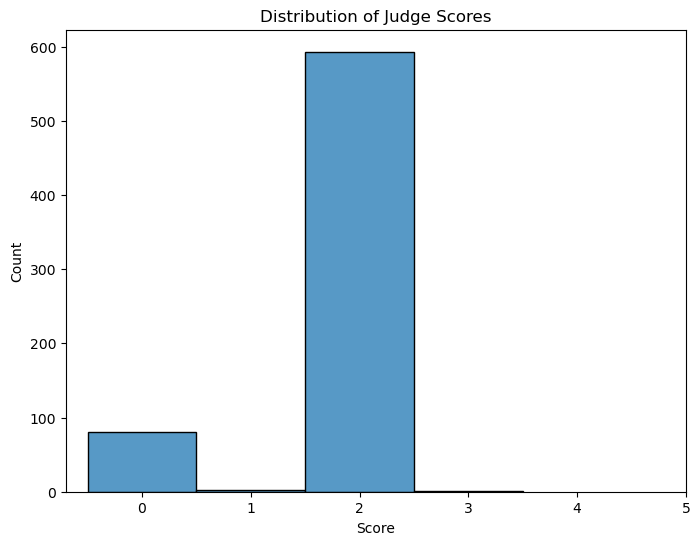

In [104]:
# Now the score distribution for the prediction which the judge considers as correct answer

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df[judged_incorrect_mask]['score'], discrete=True, bins=6)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()

## Evaluation on the entire dataset

Let's do some visualization also for the ground truth data

In [ ]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


In [ ]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6802, 4)

In [ ]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [ ]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 29.43%


In [ ]:
eval_df[eval_df['text'] == eval_df['pred_text']]


,choices,num,text,pred_text
id,,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes,The clothes
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes,The clothes
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe,The shoe
Interaction_T1_71,"{'0': 'The paper/notebook.', '1': 'The clothes...",0,The paper/notebook,The paper/notebook
Interaction_T1_100,"{'0': 'The table.', '1': 'The towel.', '2': 'T...",3,The blanket,The blanket
...,...,...,...,...
Feasibility_T6_1375,"{'0': 'Put down the clothes.', '1': 'Take the ...",2,Sit at the table,Sit at the table
Feasibility_T6_1412,"{'0': 'Put down the box.', '1': 'Hold the book...",1,Hold the book,Hold the book
Feasibility_T6_1414,"{'0': 'Throw the bag.', '1': 'Close the laptop...",3,Open the book,Open the book


check if the equality with NA result in a false or is skipped

In [ ]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 28.21%


In [ ]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [ ]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2310        25.80%  
Sequence            3409        31.68%  
Prediction           599        31.22%  
Feasibility          484        28.72%  


In [ ]:
index_intersect = predictions_df[html_tags_mask].index.intersection(eval_df.index)
print_acc(eval_df.loc[index_intersect], accuracy)


Question type       Total      Accuracy 

Interaction         1179        44.61%  
Sequence            1792        47.88%  
Prediction           333        39.64%  
Feasibility          267        42.70%  


In [ ]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        96.33%  
Sequence            3586        95.06%  
Prediction           624        95.99%  
Feasibility          490        98.78%  
Overall             7098        95.83%  
